In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from obspy import read
import glob

In [2]:
def load_data(file_path):
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df.columns = ['time_abs', 'time_rel_sec', 'velocity_m_s']
        elif file_path.endswith('.mseed'):
            st = read(file_path)
            df = pd.DataFrame({
                'time_abs': st[0].times('timestamp'),
                'time_rel_sec': st[0].times(),
                'velocity_m_s': st[0].data
            })
        
        df['time_rel_sec'] = pd.to_numeric(df['time_rel_sec'], errors='coerce')
        df['velocity_m_s'] = pd.to_numeric(df['velocity_m_s'], errors='coerce')
        
        if df.isnull().values.any():
            print(f"Fichier {file_path}: Contient des valeurs NaN après conversion.")
            df.dropna(inplace=True)
        
        return df
    except Exception as e:
        print(f"Erreur lors du chargement du fichier {file_path}: {str(e)}")
        return None


In [3]:
def calculate_power_and_energy(df):
    try:
        # Calcul de la Transformée de Fourier
        frequencies = np.fft.fftfreq(len(df['velocity_m_s']), d=np.mean(np.diff(df['time_rel_sec'])))
        fft_values = np.fft.fft(df['velocity_m_s'])
        
        # Filtrage de la fréquence principale (supprimer les fréquences très basses)
        frequencies = frequencies[frequencies > 0]
        fft_values = fft_values[:len(frequencies)]
        main_frequency = np.abs(frequencies[np.argmax(np.abs(fft_values))])
        
        # Calcul de la puissance et de l'énergie
        df['power'] = (df['velocity_m_s'] ** 2) / np.sqrt(main_frequency)
        df['energy'] = np.cumsum(df['power'] * np.diff(np.concatenate(([0], df['time_rel_sec']))))
        
        # Lissage avec Savitzky-Golay (vérification de la taille des données pour window_length)
        window_length = min(51, len(df['power']))  # Assurez-vous que la fenêtre est valide
        if window_length % 2 == 0:  # Assurez-vous que window_length est impair
            window_length -= 1
        
        df['smoothed_power'] = savgol_filter(df['power'], window_length=window_length, polyorder=3)
        
        return df
    except Exception as e:
        print(f"Erreur lors du calcul de la puissance et de l'énergie: {str(e)}")
        return None


In [4]:
def detect_seismic_events(df, power_threshold_factor=5, energy_threshold_factor=5, min_distance=1000):
    try:
        # Lissage préalable
        df['smoothed_power'] = savgol_filter(df['power'], window_length=min(51, len(df['power'])), polyorder=3)

        # Calcul des seuils
        power_threshold = np.mean(df['smoothed_power']) + power_threshold_factor * np.std(df['smoothed_power'])
        energy_rate = np.diff(df['energy']) / np.diff(df['time_rel_sec'])
        energy_threshold = np.mean(energy_rate) + energy_threshold_factor * np.std(energy_rate)

        # Détection des pics
        power_peaks, _ = find_peaks(df['smoothed_power'], height=power_threshold, distance=min_distance)
        energy_peaks, _ = find_peaks(energy_rate, height=energy_threshold, distance=min_distance)

        # Fusion des deux séries de pics
        all_peaks = sorted(set(power_peaks) | set(energy_peaks))

        return all_peaks
    except Exception as e:
        print(f"Erreur lors de la détection des événements: {str(e)}")
        return []


In [5]:
def find_event_boundaries(df, peak, window_size=500, power_threshold_factor=0.1, energy_threshold_factor=0.1):
    try:
        start_index = max(0, peak - window_size)
        end_index = min(len(df), peak + window_size)

        event_window = df.iloc[start_index:end_index]

        power_threshold = power_threshold_factor * df['smoothed_power'].iloc[peak]
        energy_threshold = energy_threshold_factor * (df['energy'].iloc[peak] - df['energy'].iloc[start_index])

        # Trouver le début de l'événement
        for i in range(peak, start_index, -1):
            if df['smoothed_power'].iloc[i] < power_threshold and (
                    df['energy'].iloc[peak] - df['energy'].iloc[i]) < energy_threshold:
                start = i
                break
        else:
            start = start_index

        # Trouver la fin de l'événement
        for i in range(peak, end_index):
            if df['smoothed_power'].iloc[i] < power_threshold and (
                    df['energy'].iloc[i] - df['energy'].iloc[peak]) < energy_threshold:
                end = i
                break
        else:
            end = end_index

        return start, end
    except Exception as e:
        print(f"Erreur lors de la recherche des limites de l'événement: {str(e)}")
        return peak, peak  # Retour par défaut si une erreur survient


In [6]:
def plot_results(df, events):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20), sharex=True)

    ax1.plot(df['time_rel_sec'], df['velocity_m_s'], label='Vitesse', color='green')
    ax1.set_ylabel('Vitesse (m/s)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(df['time_rel_sec'], df['power'], label='Puissance', color='blue', alpha=0.5)
    ax2.plot(df['time_rel_sec'], df['smoothed_power'], label='Puissance lissée', color='darkblue')
    ax2.set_ylabel('Puissance (W)')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(df['time_rel_sec'], df['energy'], label='Énergie cumulée', color='red')
    ax3.set_xlabel('Temps Relatif (sec)')
    ax3.set_ylabel('Énergie (J)')
    ax3.legend()
    ax3.grid(True)

    for start, peak, end in events:
        for ax in (ax1, ax2, ax3):
            ax.axvline(x=df['time_rel_sec'].iloc[start], color='green', linestyle='--', alpha=0.7)
            ax.axvline(x=df['time_rel_sec'].iloc[peak], color='purple', linestyle='--', alpha=0.7)
            ax.axvline(x=df['time_rel_sec'].iloc[end], color='red', linestyle='--', alpha=0.7)

    plt.title('Analyse des Données Sismiques')
    plt.tight_layout()
    plt.show()

In [7]:
def process_file(file_path):
    print(f"Traitement du fichier : {file_path}")
    df = load_data(file_path)
    df = calculate_power_and_energy(df)
    peaks = detect_seismic_events(df)

    events = []
    for peak in peaks:
        start, end = find_event_boundaries(df, peak)
        events.append((start, peak, end))

    plot_results(df, events)

    return {
        'file': file_path,
        'events': [(df['time_abs'].iloc[start], df['time_abs'].iloc[peak], df['time_abs'].iloc[end]) for
                   start, peak, end in events]
    }

In [8]:
def process_all_files(directory):
    file_patterns = ['*.csv', '*.mseed']
    all_files = []
    for pattern in file_patterns:
        all_files.extend(glob.glob(f"{directory}/{pattern}"))

    results = [process_file(file) for file in all_files]
    return results

In [9]:
def plot_full_signal(df, events):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20), sharex=True)

    ax1.plot(df['time_rel_sec'], df['velocity_m_s'], label='Vitesse', color='green')
    ax1.set_ylabel('Vitesse (m/s)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(df['time_rel_sec'], df['power'], label='Puissance', color='blue', alpha=0.5)
    ax2.plot(df['time_rel_sec'], df['smoothed_power'], label='Puissance lissée', color='darkblue')
    ax2.set_ylabel('Puissance (W)')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(df['time_rel_sec'], df['energy'], label='Énergie cumulée', color='red')
    ax3.set_xlabel('Temps Relatif (sec)')
    ax3.set_ylabel('Énergie (J)')
    ax3.legend()
    ax3.grid(True)

    for start, peak, end in events:
        for ax in (ax1, ax2, ax3):
            ax.axvline(x=df['time_rel_sec'].iloc[start], color='green', linestyle='--', alpha=0.7)
            ax.axvline(x=df['time_rel_sec'].iloc[peak], color='purple', linestyle='--', alpha=0.7)
            ax.axvline(x=df['time_rel_sec'].iloc[end], color='red', linestyle='--', alpha=0.7)

    plt.title('Analyse Complète des Données Sismiques')
    plt.tight_layout()
    plt.show()

In [10]:
def find_main_oscillation(df, power_threshold_factor=5, min_duration=10, max_duration=300):
    try:
        if len(df) == 0:
            print("Le DataFrame est vide.")
            return None, None

        power_threshold = np.mean(df['smoothed_power']) + power_threshold_factor * np.std(df['smoothed_power'])
        
        above_threshold = df['smoothed_power'] > power_threshold
        oscillation_starts = np.where(above_threshold[:-1] == False)[0]
        oscillation_ends = np.where(above_threshold[1:] == False)[0] + 1

        # Assurez-vous que nous avons le même nombre de débuts et de fins
        min_length = min(len(oscillation_starts), len(oscillation_ends))
        oscillation_starts = oscillation_starts[:min_length]
        oscillation_ends = oscillation_ends[:min_length]
        
        valid_oscillations = []
        for start, end in zip(oscillation_starts, oscillation_ends):
            if start >= len(df) or end >= len(df):
                continue  # Ignorez les oscillations qui dépassent les limites du DataFrame
            duration = df['time_rel_sec'].iloc[end] - df['time_rel_sec'].iloc[start]
            if min_duration <= duration <= max_duration:
                valid_oscillations.append((start, end))
        
        if not valid_oscillations:
            print("Aucune oscillation valide trouvée.")
            return None, None
        
        main_oscillation = max(valid_oscillations, key=lambda x: df['smoothed_power'].iloc[x[0]:x[1]].max())
        
        return main_oscillation
    except Exception as e:
        print(f"Erreur lors de la recherche de l'oscillation principale: {str(e)}")
        return None, None

In [11]:
def plot_seismic_event(df, start, end):
    try:
        if start is None or end is None or start >= len(df) or end >= len(df) or start < 0 or end < 0:
            print("Indices de début ou de fin invalides pour le tracé.")
            return

        # Assurez-vous que start est inférieur à end
        start, end = min(start, end), max(start, end)

        # Limitez end à la longueur du DataFrame
        end = min(end, len(df) - 1)

        event_df = df.iloc[start:end+1]
        
        if len(event_df) == 0:
            print("Aucune donnée à tracer pour l'événement.")
            return

        # Trouvez le pic dans l'intervalle de l'événement
        peak = start + event_df['smoothed_power'].idxmax() - event_df.index[0]
        peak = max(0, min(peak, len(event_df) - 1))  # Assurez-vous que peak est dans les limites

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
        
        ax1.plot(event_df['time_rel_sec'], event_df['velocity_m_s'], label='Vitesse', color='green')
        ax1.set_ylabel('Vitesse (m/s)')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(event_df['time_rel_sec'], event_df['power'], label='Puissance', color='blue', alpha=0.5)
        ax2.plot(event_df['time_rel_sec'], event_df['smoothed_power'], label='Puissance lissée', color='darkblue')
        ax2.set_ylabel('Puissance (W)')
        ax2.set_yscale('log')
        ax2.legend()
        ax2.grid(True)
        
        ax3.plot(event_df['time_rel_sec'], event_df['energy'], label='Énergie cumulée', color='red')
        ax3.set_xlabel('Temps Relatif (sec)')
        ax3.set_ylabel('Énergie (J)')
        ax3.legend()
        ax3.grid(True)
        
        for ax in (ax1, ax2, ax3):
            ax.axvline(x=event_df['time_rel_sec'].iloc[0], color='green', linestyle='--', alpha=0.7, label='Début')
            ax.axvline(x=event_df['time_rel_sec'].iloc[peak], color='purple', linestyle='--', alpha=0.7, label='Pic')
            ax.axvline(x=event_df['time_rel_sec'].iloc[-1], color='red', linestyle='--', alpha=0.7, label='Fin')
        
        plt.title(f'Événement Sismique Principal (Début: {event_df["time_rel_sec"].iloc[0]:.2f}s, Fin: {event_df["time_rel_sec"].iloc[-1]:.2f}s)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erreur lors de la création du graphique: {str(e)}")
        print(f"Détails - start: {start}, end: {end}, len(df): {len(df)}")

In [12]:

def process_file(file_path):
    print(f"Traitement du fichier : {file_path}")
    df = load_data(file_path)
    if df is None or len(df) == 0:
        print(f"Impossible de charger ou DataFrame vide pour {file_path}")
        return {'file': file_path, 'event': None}
    
    df = calculate_power_and_energy(df)
    if df is None:
        print(f"Erreur lors du calcul de la puissance et de l'énergie pour {file_path}")
        return {'file': file_path, 'event': None}
    
    start, end = find_main_oscillation(df)
    if start is not None and end is not None:
        plot_seismic_event(df, start, end)
        return {
            'file': file_path,
            'event': (df['time_abs'].iloc[start], df['time_abs'].iloc[end])
        }
    else:
        print(f"Aucun événement sismique principal détecté pour {file_path}")
        return {'file': file_path, 'event': None}

Traitement du fichier : xa.s12.00.mhz.1971-05-23HR00_evid00034.csv


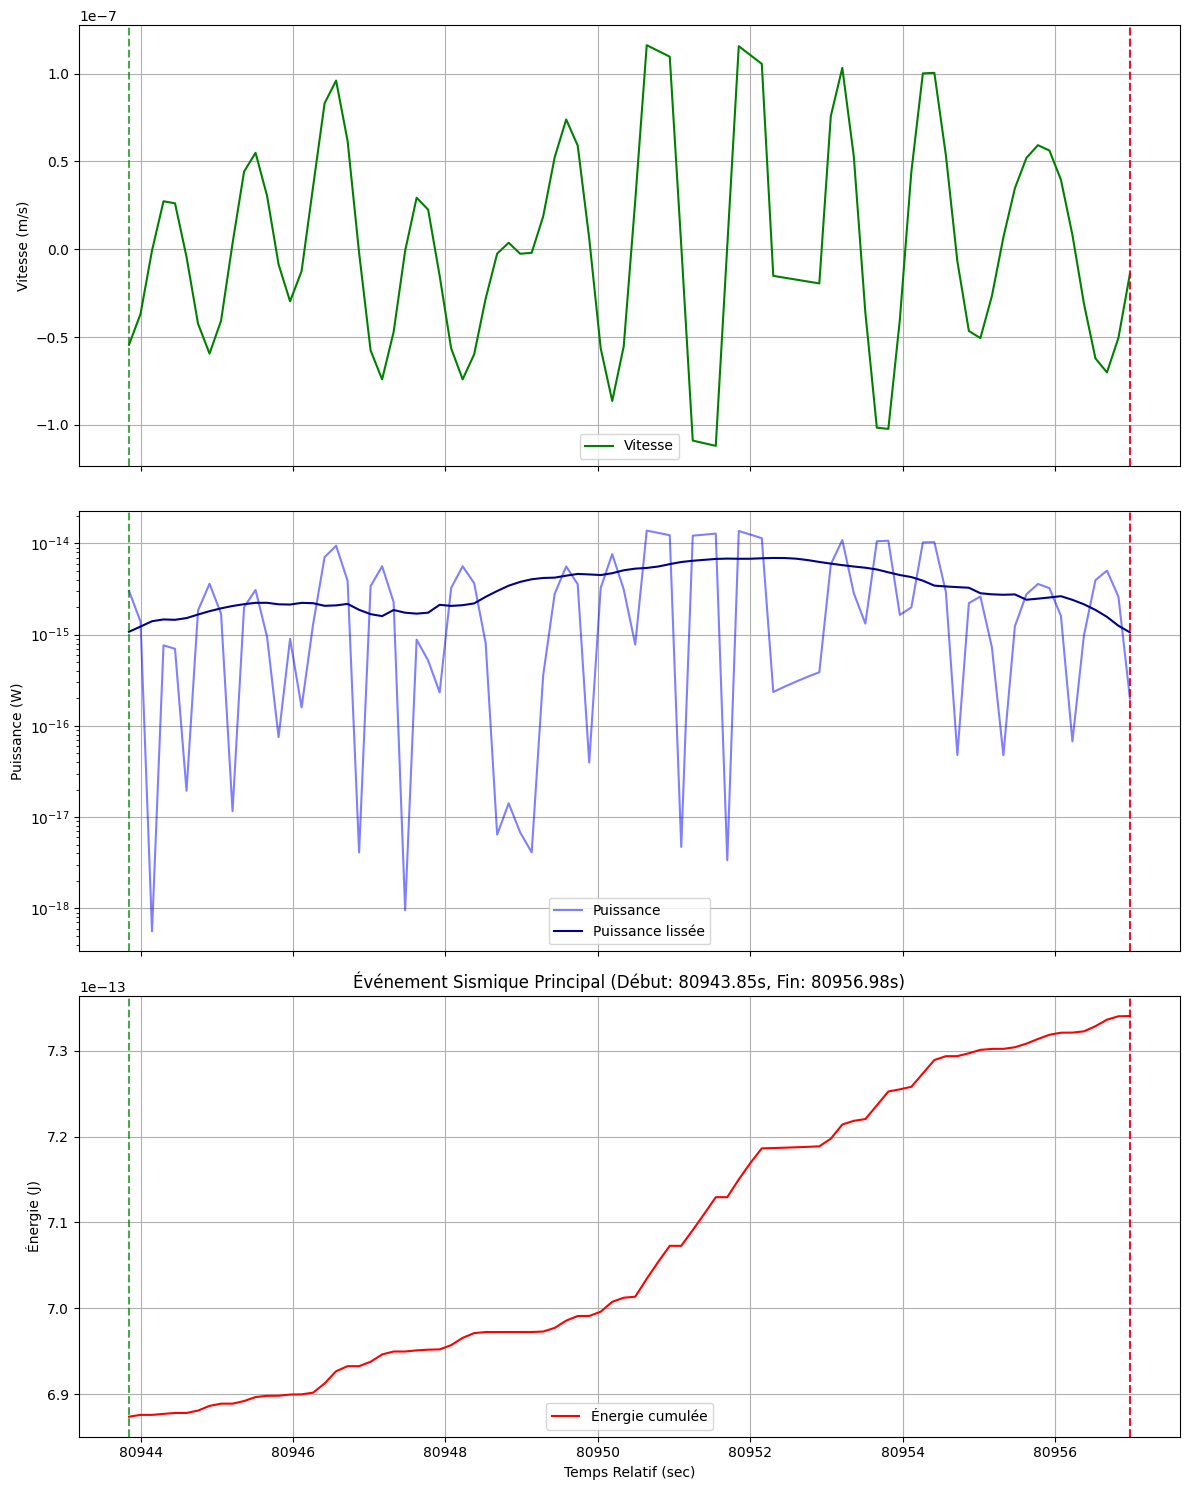

Traitement du fichier : xa.s12.00.mhz.1971-05-23HR00_evid00034.csv


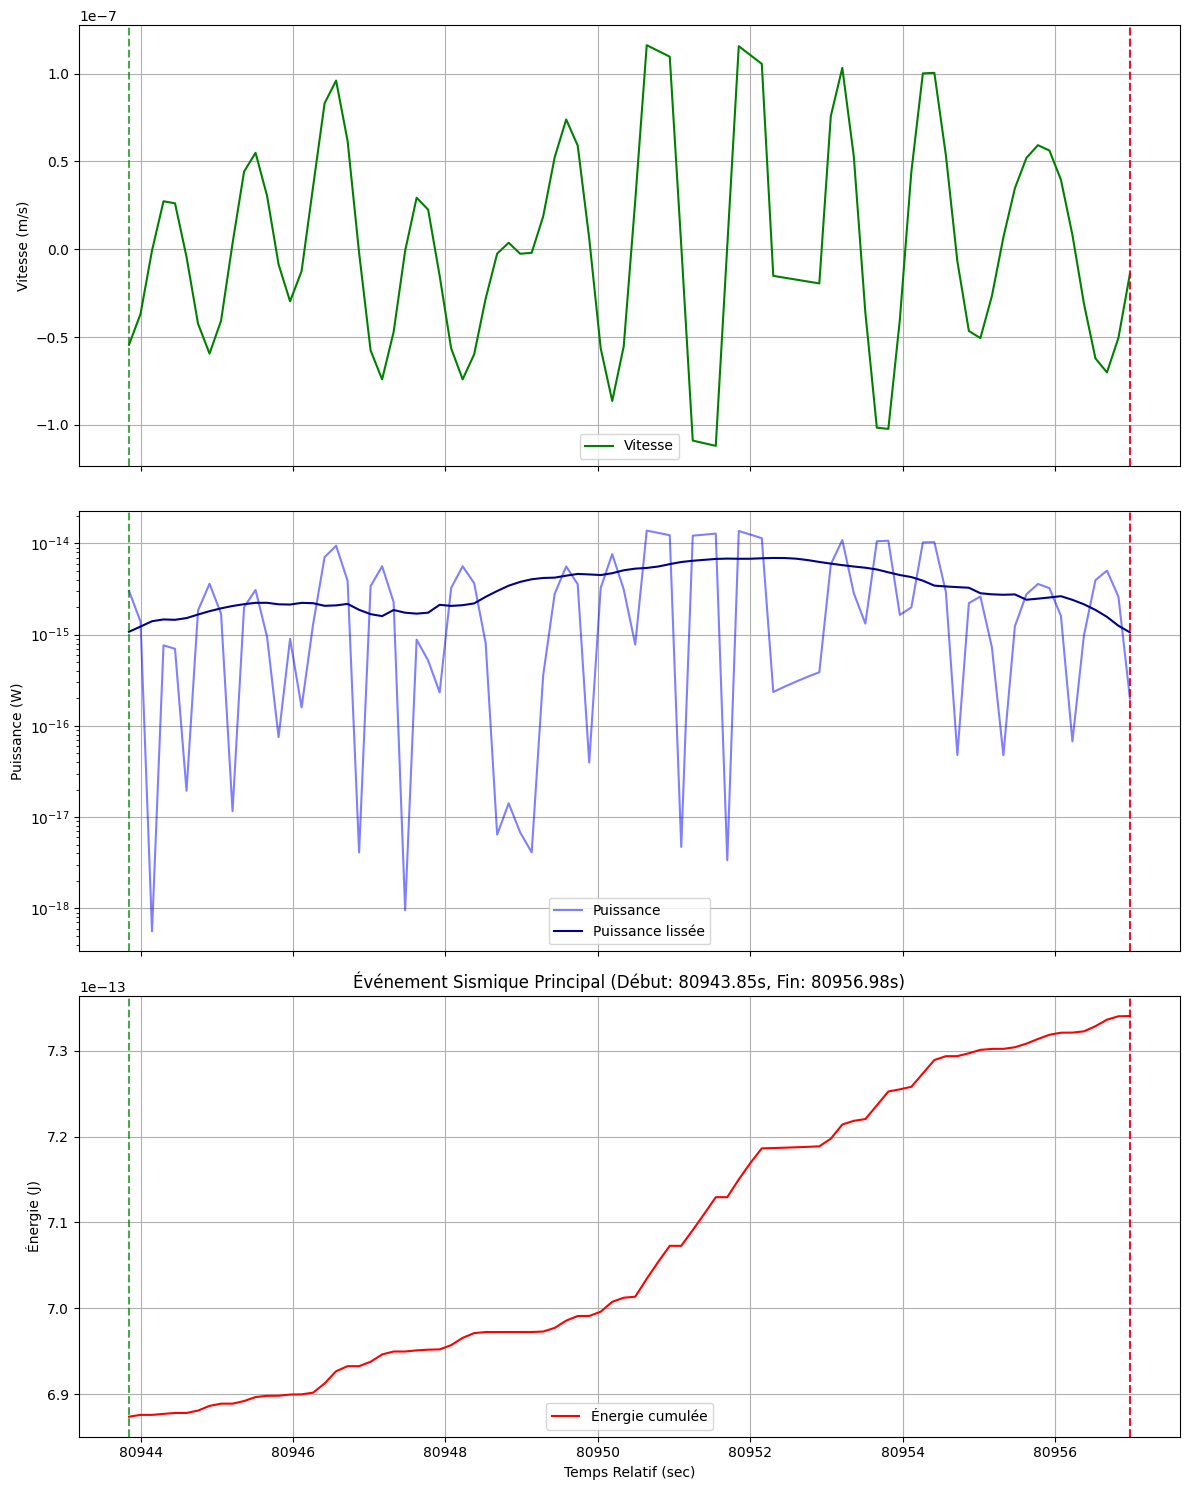


Fichier: xa.s12.00.mhz.1971-05-23HR00_evid00034.csv
Événement sismique principal détecté:
  Début: 1971-05-23T22:29:04.351057
  Fin: 1971-05-23T22:29:17.483132

Fichier: xa.s12.00.mhz.1971-05-23HR00_evid00034.csv
Événement sismique principal détecté:
  Début: 1971-05-23T22:29:04.351057
  Fin: 1971-05-23T22:29:17.483132


In [13]:

def process_all_files(directory):
    file_patterns = ['*.csv', '*.mseed']
    all_files = []
    for pattern in file_patterns:
        all_files.extend(glob.glob(f"xa.s12.00.mhz.1971-05-23HR00_evid00034.csv"))
    
    results = []
    for file in all_files:
        try:
            result = process_file(file)
            results.append(result)
        except Exception as e:
            print(f"Erreur lors du traitement du fichier {file}: {str(e)}")
    
    return results

directory = 'xa.s12.00.mhz.1973-01-18HR00_evid00088.csv'
results = process_all_files(directory)

# Afficher les résultats
for result in results:
    print(f"\nFichier: {result['file']}")
    if result['event']:
        start, end = result['event']
        print(f"Événement sismique principal détecté:")
        print(f"  Début: {start}")
        print(f"  Fin: {end}")
    else:
        print("Aucun événement sismique principal détecté.")